# Building an SVM Solver

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import optLib as opt
from matplotlib import pyplot as plt
import time as tm
import random

**Generating Toy Data** this dataset will be a set of two circles with a couple of outliers and one that we know is challenging even for SVMs. We saw that the $C$ value in the CSVM formulation controls how worried does the CSVM get about misclassifying data points. Recall that having a very large value of $C$ can make the CSVM problem more difficult (and more time consuming) to solve. Let us see whether our solvers are able to work well for large values of $C$ or not.

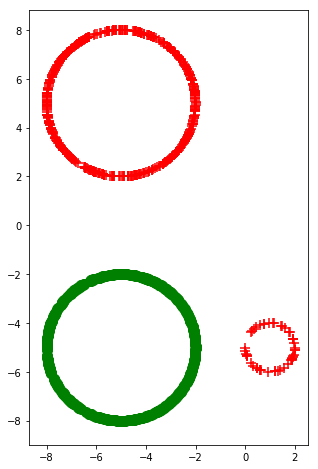

In [3]:
d = 2 
n = 500

muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

nOutlier = n//10
rOutlier = r//2

tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, nOutlier, muPos2, rOutlier )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + nOutlier,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig = pd.getFigure( 5, 8 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )

**Implementing a dual solver for CSVM**: given the current dual model (the $\mathbf \alpha$ vector) and a coordinate which to update, we perform optimization along that coordinate to find its optimal value. In order to speed up the computations and
to ensure that each dual coordinate update takes only $\mathcal O(d)$ time, we are secretly maintaining the primal model as well (the way we are doing so by maintaining global variables is clunky and not recommended but it is easy :) )

In [4]:
def mySVM( X ):
    return X.dot(w) + b

# Stochastic Dual Coordinate Maximization
def doCoordOptCSVMDual( alpha, i, t ):
    global w_SDCM, b_SDCM, normSq
    x = X[i,:]
    
    # Find the unconstrained new optimal value of alpha_i
    # It takes only O(d) time to do so because of our clever book keeping
    newAlphai =  alpha[i] + (1 - y[i] * (x.dot(w_SDCM) + b_SDCM)) / normSq[i]
    
    # Make sure that the constraints are satisfied. This takes only O(1) time
    if newAlphai > C:
        newAlphai = C
    if newAlphai < 0:
        newAlphai = 0

    # Update the primal model vector and bias values to ensure bookkeeping is proper
    # Doing these bookkeeping updates also takes only O(d) time
    w_SDCM = w_SDCM + (newAlphai - alpha[i]) * y[i] * x
    b_SDCM = b_SDCM + (newAlphai - alpha[i]) * y[i]
    
    return newAlphai

# Get the primal and the dual CSVM objective values in order to plot convergence curves
# This is required for the dual solver which optimizes the dual objective function
def getCSVMPrimalDualObjVals( alpha ):
    global w_SDCM, b_SDCM
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w_SDCM ) + b_SDCM), y ), 0 )
    objPrimal = 0.5 * w_SDCM.dot( w_SDCM ) + C * np.sum(hingeLoss)
    # Recall that b is supposed to be treated as the last coordinate of w
    objDual = np.sum( alpha ) - 0.5 * np.square( np.linalg.norm( w_SDCM ) ) - 0.5 * b_SDCM * b_SDCM
    
    return np.array( [objPrimal, objDual] )

**Benchmarking**: we will also be implementing the SGD algorithm to compare which algorithm performs better. In several situations, SDCM may perform better than SGD when dealing with more challenging problems e.g. those with large values of the $C$ hyperparameter in CSVM. SGD can get sluggish with difficult problems and stop making progress. SCDM performs very well with the randperm method of choosing coordinates as compared to random or cyclic choice of coordinates. The randperm method is the default coordinate choice method even in professional solvers like liblinear.

In [5]:
# Get the CSVM primal objective value in order to plot convergence curves
def getCSVMPrimalObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * np.sum( hingeLoss )

# Get a stochastic gradient for the CSVM objective
# Choose a random data point per iteration
def getCSVMSGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    i = random.randint( 0, n-1 )
    x = X[i,:]
    discriminant = (x.dot( w ) + b) * y[i]
    g = 0
    if discriminant < 1:
        g = -1
    delb = C * n * g * y[i]
    delw = w + C * n * (x * g) * y[i]
    return np.append( delw, delb )

In [6]:
C = 10
eta = 2
stepFunc = opt.stepLengthGenerator( "linear", eta )
coordFunc = opt.coordinateGenerator( "randperm", y.size )

# Create initializations for both the SGD as well as the SDCM solvers
initPrimal = np.zeros( (d+1,) )
initDual = C * np.ones( (y.size,) )

# The SDCM solver needs to repeatedly calculate the squared norms of the feature vector.
# Calculate them once and for all to improve efficienty. While calculating the norms, take
# care that we are appending an extra dimension of ones to all feature vectors to hide the bias
normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1

# Initialize bookkeeping variables for the SDCM solver.
# Initialize the primal model vector using the equations relating primal and dual variables
alphayInit = np.multiply( initDual, y )
w_SDCM = X.T.dot( alphayInit )
# Recall that we are pretending that the data points have one extra dimension of ones
# This extra dimension plays the role of the bias in this case
b_SDCM = initDual.dot( y )

(theta_SGD, obj_SGD, time_SGD) = opt.doGD( getCSVMSGrad, stepFunc, getCSVMPrimalObjVal, initPrimal, horizon = 10 * n, doModelAveraging = True )
(alpha_SDCM, obj_SDCM, time_SDCM) = opt.doSDCM( doCoordOptCSVMDual, coordFunc, getCSVMPrimalDualObjVals, initDual, horizon = 10 * n )

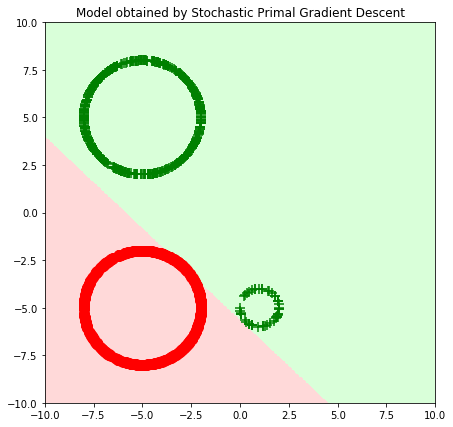

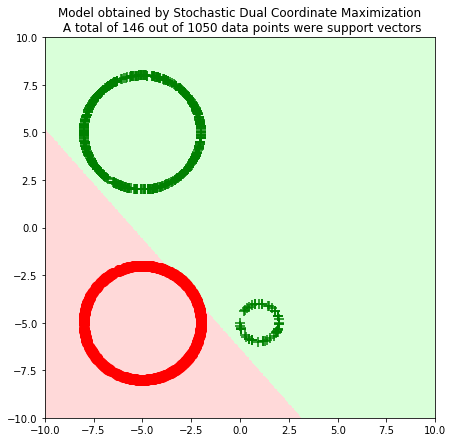

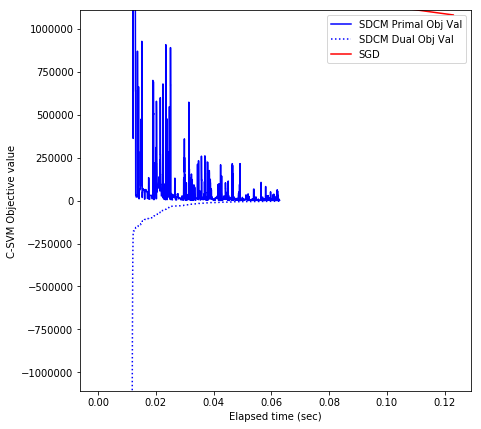

In [7]:
w = theta_SGD[0:-1]
b = theta_SGD[-1]

fig2 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig2, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig2, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'r', marker = 'o' )
plt.title( "Model obtained by Stochastic Primal Gradient Descent" )
plt.show()

w = w_SDCM
b = b_SDCM

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'r', marker = 'o' )
plt.title( "Model obtained by Stochastic Dual Coordinate Maximization\n A total of %d out of %d data points were support vectors" % (np.sum( alpha_SDCM > C/100 ), y.size) )
plt.show()

fig4 = pd.getFigure( 7, 7 )
plt.figure( fig4.number )
primal_SDCM = [obj_SDCM[i][0] for i in range(len(obj_SDCM))]
dual_SDCM = [obj_SDCM[i][1] for i in range(len(obj_SDCM))]
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal Obj Val" )
plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
# Plot the results of the last blah iterates of all methods
blah = 500
scale = max(obj_SGD[-blah], primal_SDCM[-blah], -dual_SDCM[-blah])
plt.ylim( -scale, scale )
plt.show()